In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# Step 1: Brief description of the problem and data (5 pts)
> Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

**Author:** Elizabeth Martin <br>
**Github:** [week-5-monet-GAN](https://github.com/Elizabeth-Martin2/machine-learning/tree/main/deep-learning) <br>
**Link to Kaggle competition:** [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview) <br>

**Description:** This is a **kaggle** competition to create a **Generative Adversarial Network (GAN)** to generate images in the style of Claude Monet.  We will submit them to the kaggle evaluator where they will be ranked on **Memorization-informed Fréchet Inception Distance (MiFID)**.  

**Data:** The competition provides four datasets: two with JPGs of Monet paintings & regular photos, and two with TFRECs of Monet paintings & regular photos. 

**Important:** I was having module errors in my own notebook, but when testing with the tutorial notebook, they were resolved.  Thus I have used it as a base for my assignment and made changes to the hyperparameters & functions.

## Table of Contents
1. [Introduction](#Step-1:-Brief-description-of-the-problem-and-data-(5-pts))
2. [EDA](#Step-2:-Exploratory-Data-Analysis-(EDA)-—-Inspect,-Visualize-and-Clean-the-Data-(15-pts))
3. [Model Architecture](#Step-3:-Model-Architecture-(25-pts))
4. [Results & Analysis](#Step-4:-Results-and-Analysis-(35-pts))
5. [Conclusion](#Step-5:-Conclusion-(15-pts))
6. [References](#References)

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

print(f'There are {len(MONET_FILENAMES)} Monet TFRecord files.')
print(f'There are {len(PHOTO_FILENAMES)} photo TFRecord files.')

There are 5 Monet TFRecord files.
There are 20 photo TFRecord files.


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [3]:
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [5]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

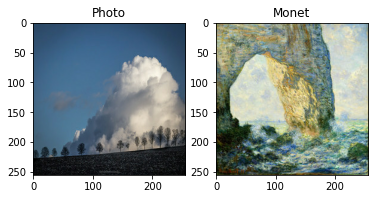

In [6]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

For this dataset, there isn't any cleaning we need to do.  We have already been provided the images, so we will be spending the majority of our time converting the provided photos to Monet style.

# Step 3: Model Architecture (25 pts)
> Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

The next couple of functions essentially scale the image down and up.  The downsampling reduces the spatial dimensions of the feature map & aggregates information from adjacent pixels.  The upsampling does the opposite, increasing the spaital dimensions to recover lost spatial information caused by downsampling.  

These are used by the generator and discriminator, respectively, allowing the generator to generate realistic high-resolution images and the discriminator to distinguish between real and generated images at different resolutions!

In [7]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    downsample_model = keras.Sequential()
    downsample_model.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        downsample_model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # This will help with stability to preserve earlier neurons
    downsample_model.add(layers.LeakyReLU()) 

    return downsample_model

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    upsample_model = keras.Sequential()
    upsample_model.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    upsample_model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        # Dropout helps with overfitting
        upsample_model.add(layers.Dropout(0.5))

    upsample_model.add(layers.ReLU())

    return upsample_model

My generator architecture will follow a U-Net-like design.  It has symmetric encoding and decoding connected by skip connections.  I have commented out a few layers in an attempt to simplify the model as the first time I submitted, it didn't perform as well.

In [8]:
def MyGenerator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Define downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        #downsample(512, 4),  # (bs, 8, 8, 512)   # Commenting this out to reduce complexity
        #downsample(512, 4),  # (bs, 4, 4, 512)   # Commenting this out to reduce complexity
        #downsample(512, 4),  # (bs, 2, 2, 512)   # Commenting this out to reduce complexity
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Define upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        #upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024) # Commenting this out to reduce complexity
        #upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024) # Commenting this out to reduce complexity
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    # This initializes the weights & dines the final convolutional layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    x = inputs
    
    # Apply downsampling layers
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x) # This saves the output of each downsampling layer for the skip connection

    skips = reversed(skips[:-1])

    # Apply upsampling layers and concatenate skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # This concatenates the output of the current upsampling layer with the skip connection
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)


The discriminator uses convolutional layers to discriminate between real & fake images.  The image passes through downsampling layers to extract hierarchical features from the input image, then passes through a convolutional layer to further process the feature and capture more complex patterns.  We're using normalization & leaky relu to apply the features to enhance learning & stabilize the training process.  

In [9]:
def MyDiscriminator():
    # Initialize weights and biases
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    # Input layer
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    # Downsample layers
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)    # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)    # (bs, 32, 32, 256)

    # Convolutional layer
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)    
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
    
    # Instance normalization and activation
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    
    # Output layer
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)    
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
# The following line is a context manager for Tensor Flow's distributed training  API
with strategy.scope():
    monet_generator = MyGenerator()
    photo_generator = MyGenerator()

    monet_discriminator = MyDiscriminator()
    photo_discriminator = MyDiscriminator()

In [11]:
# This is the same as the tutorial's structure, there's not much to change here as it's the general structure for a GAN
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [12]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [13]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [14]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [15]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [16]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [18]:
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=50)

Epoch 1/25
300/300 [==============================] - 97s 201ms/step - monet_gen_loss: 5.0808 - photo_gen_loss: 5.2549 - monet_disc_loss: 0.6547 - photo_disc_loss: 0.6409
Epoch 2/25
300/300 [==============================] - 65s 203ms/step - monet_gen_loss: 3.5944 - photo_gen_loss: 3.6815 - monet_disc_loss: 0.6580 - photo_disc_loss: 0.6406
Epoch 3/25
300/300 [==============================] - 67s 206ms/step - monet_gen_loss: 3.4974 - photo_gen_loss: 3.6145 - monet_disc_loss: 0.6549 - photo_disc_loss: 0.6155
Epoch 4/25
300/300 [==============================] - 64s 200ms/step - monet_gen_loss: 3.3605 - photo_gen_loss: 3.5341 - monet_disc_loss: 0.6480 - photo_disc_loss: 0.6054
Epoch 5/25
300/300 [==============================] - 65s 202ms/step - monet_gen_loss: 3.2552 - photo_gen_loss: 3.3836 - monet_disc_loss: 0.6372 - photo_disc_loss: 0.6198
Epoch 6/25
300/300 [==============================] - 63s 197ms/step - monet_gen_loss: 3.1546 - photo_gen_loss: 3.2480 - monet_disc_loss: 0.6323 

# Step 4: Results and Analysis (35 pts)
> Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

I have used the tutorial as a base and modified the epochs, architecture, and played around with the normalization.  The batch normalization instead gave a higher MiFID score (which is bad) and the additional layers only added complexity.  It seems like the only change that makes a difference is an increase in epochs and a simpler model.

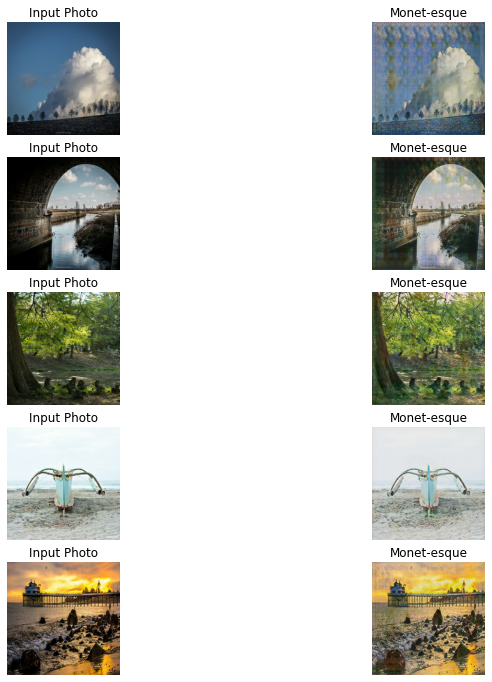

In [19]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Results from 50 epochs: <br>
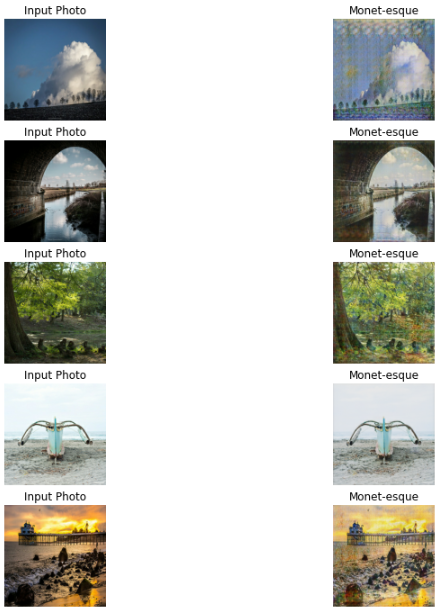

# Step 5: Conclusion (15 pts)
> Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

I tried a few iterations of hyperparameter changes, such as batch normalization, and different activation functions, but the only significant difference was by simplifying the model, and increasing the number of iterations.  With these changes the MiFID score which was previously at 59.67776 decreased to 53.71279.  Recall that a decrease in MiFID signifies the generated images have improved!

Some ideas for future improvements:
1. Implement data augmentation - random flips, crops, or color jittering
2. Try other GANs such as CycleGAN, Pix2Pix, or StyleGan
3. Other adversarial training strategies - curriculum learning, self-ensembling, or adversarial training with gradiant penalty

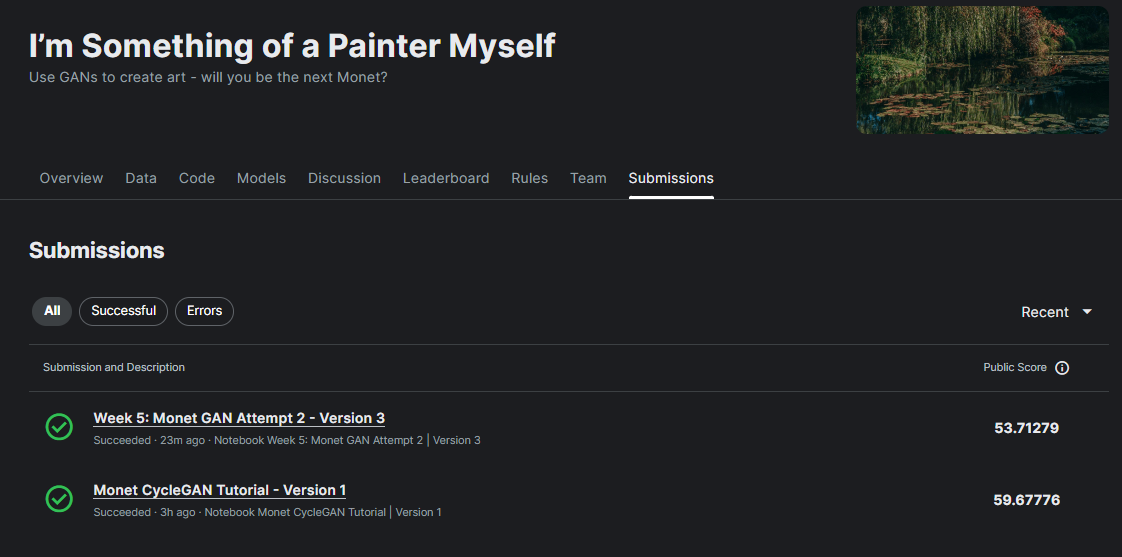

In [20]:
import PIL
! mkdir ../images

In [21]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [22]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'